In [2]:
%load_ext lab_black

In [1]:
import json
import logging
import math
import os
import random
import shutil
import sys
from collections import defaultdict
from dataclasses import dataclass
from datetime import datetime
from pathlib import Path
from typing import Callable, List, Sequence, Tuple

import albumentations as A
import cv2
import imageio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from albumentations.pytorch import ToTensorV2
from PIL import Image
from sklearn.model_selection import KFold
from torch import nn, optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset, Subset
from tqdm import tqdm

import networks
import utils
from error_list import error_list

In [3]:
POSE_MODEL = "HRNet-W48"
DET_PRETRAINED = ""
RESULT_DIR = Path("results/hrnet+det")

LR = 1e-4  # transfer learning이니깐 좀 작게 주는게 좋을 것 같아서 1e-4
BATCH_SIZE = 40
START_EPOCH = 1
SAM = True
FOLDS = [1, 2, 3, 4, 5]
PADDING = 30

n = datetime.now()
UID = f"{n.year:04d}{n.month:02d}{n.day:02d}-{n.hour:02d}{n.minute:02d}{n.second:02d}"
SEED = 20210309

In [4]:
total_imgs = np.array(sorted(list(Path("data/ori/train_imgs/").glob("*.jpg"))))
test_imgs = np.array(sorted(list(Path("data/ori/test_imgs/").glob("*.jpg"))))

df = pd.read_csv("data/ori/train_df.csv")
total_keypoints = df.to_numpy()[:, 1:].astype(np.float32)
total_keypoints = np.stack([total_keypoints[:, 0::2], total_keypoints[:, 1::2]], axis=2)

In [30]:
total_imgs_, total_keypoints_ = [], []
for i in range(len(total_imgs)):
    if i not in error_list:
        total_imgs_.append(total_imgs[i])
        total_keypoints_.append(total_keypoints[i])
total_imgs = np.array(total_imgs_)
total_keypoints = np.array(total_keypoints_)

In [5]:
class KeypointDataset(Dataset):
    def __init__(self, files, keypoints, augmentation=True, padding=30):
        super().__init__()
        self.files = files
        self.keypoints = keypoints
        self.padding = padding

        T = []
        # T.append(A.Crop(0, 28, 1920, 1080 - 28))  # 1920x1080 --> 1920x1024
        # T.append(A.Resize(512, 1024))
        if augmentation:
            T.append(A.ImageCompression())
            T.append(A.ShiftScaleRotate(border_mode=cv2.BORDER_CONSTANT, value=0, rotate_limit=0))
            T.append(utils.HorizontalFlipEx())
            T.append(A.Cutout())
            T_ = []
            T_.append(A.RandomBrightnessContrast())
            T_.append(A.RandomGamma())
            T_.append(A.RandomBrightness())
            T_.append(A.RandomContrast())
            T.append(A.OneOf(T_))
            T.append(A.GaussNoise())
            T.append(A.Blur())
        T.append(A.Normalize())
        T.append(ToTensorV2())

        self.transform = A.Compose(
            transforms=T,
            bbox_params=A.BboxParams(format="pascal_voc", label_fields=["labels"]),
            keypoint_params=A.KeypointParams(format="xy", remove_invisible=False),
            # TODO 영역을 벗어난 keypoint는 그 영역의 한도 값으로 설정해줄 것?
        )

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        image = imageio.imread(self.files[idx])

        keypoint = self.keypoints[idx]
        box = utils.keypoint2box(keypoint, self.padding)
        box = np.expand_dims(box, 0)
        labels = np.array([0], dtype=np.int64)
        a = self.transform(image=image, labels=labels, bboxes=box, keypoints=keypoint)

        image = a["image"]
        bbox = list(map(int, a["bboxes"][0]))
        keypoint = torch.tensor(a["keypoints"], dtype=torch.float32)
        image, keypoint, heatmap, ratio = self._resize_image(image, bbox, keypoint)

        return image, keypoint, heatmap, ratio

    def _resize_image(self, image, bbox, keypoint):
        # efficientdet에서 찾은 범위만큼 이미지를 자름
        image = image[:, bbox[1] : bbox[3], bbox[0] : bbox[2]]

        # HRNet의 입력 이미지 크기로 resize
        ratio = torch.tensor((288 / image.shape[2], 384 / image.shape[1]), dtype=torch.float32)
        image = F.interpolate(image.unsqueeze(0), (384, 288))[0]

        # bbox만큼 빼줌
        keypoint[:, 0] -= bbox[0]
        keypoint[:, 1] -= bbox[1]

        # 이미지를 resize해준 비율만큼 곱해줌
        keypoint[:, 0] *= ratio[0]
        keypoint[:, 1] *= ratio[1]
        # TODO: 잘못된 keypoint가 있으면 고쳐줌

        # HRNet은 1/4로 resize된 출력이 나오므로 4로 나눠줌
        keypoint /= 4

        # keypoint를 heatmap으로 변환
        # TODO: 완전히 정답이 아니면 틀린 것과 같은 점수. 좀 부드럽게 만들 수는 없을지?
        # heatmap regression loss중에 soft~~~ 한 이름이 있던거같은데
        heatmap = utils.keypoints2heatmaps(keypoint, 96, 72)

        return image, keypoint, heatmap, ratio

In [6]:
class JointMSELoss(nn.Module):
    """https://github.com/leoxiaobin/deep-high-resolution-net.pytorch/blob/master/lib/core/loss.py"""

    def __init__(self):
        super().__init__()

        self.mse = nn.MSELoss()

    def forward(self, pred: torch.Tensor, target: torch.Tensor):
        num_joints = pred.size(1)
        mse = (pred - target).square().mean((2, 3)).sum()
        loss = mse / num_joints
        return loss

In [7]:
class KeypointRMSE(nn.Module):
    @torch.no_grad()
    def forward(self, x, y, ratios):
        W = x.size(3)
        xp = x.flatten(2).argmax(2)
        xx = (xp % W) / ratios[:, 0:1] * 4
        xy = (xp // W) / ratios[:, 1:2] * 4
        yp = y.flatten(2).argmax(2)
        yx = (yp % W) / ratios[:, 0:1] * 4
        yy = (yp // W) / ratios[:, 1:2] * 4

        if random.random() <= 0.01:
            keypoints = torch.stack([xx, xy, yx, yy], 2)
            print(keypoints[0])

        diff = ((xx - yx) ** 2 + (xy - yy) ** 2) / 2
        loss = diff.mean().sqrt()
        return loss

In [8]:
@dataclass
class TrainOutputBean:
    loss = utils.AverageMeter()
    rmse = utils.AverageMeter()

    def freeze(self):
        self.loss = self.loss()
        self.rmse = self.rmse()

        return self

In [9]:
class TrainInputBean:
    def __init__(self):
        # HRNet 생성
        if POSE_MODEL == "HRNet-W32":
            width = 32
        elif POSE_MODEL == "HRNet-W48":
            width = 48
        else:
            raise NotImplementedError()

        self.pose_model = networks.PoseHighResolutionNet(width)
        self.pose_model.load_state_dict(torch.load(f"networks/models/pose_hrnet_w{width}_384x288.pth"))

        final_layer = nn.Conv2d(width, 24, 1)
        with torch.no_grad():
            final_layer.weight[:17] = self.pose_model.final_layer.weight
            final_layer.bias[:17] = self.pose_model.final_layer.bias
            self.pose_model.final_layer = final_layer
        self.pose_model.cuda()

        # Criterion / Optimizer
        self.criterion = JointMSELoss().cuda()
        self.criterion_rmse = KeypointRMSE().cuda()
        if SAM:
            self.optimizer = utils.SAM(self.pose_model.parameters(), optim.AdamW, lr=LR)
        else:
            self.optimizer = optim.AdamW(self.pose_model.parameters(), lr=LR)
        self.scheduler = ReduceLROnPlateau(self.optimizer, factor=0.5, patience=4, verbose=True)

        # 기타
        self.epoch = START_EPOCH
        self.best_loss = math.inf
        self.earlystop_cnt = 0

    def save_checkpoint(self, path):
        torch.save(
            {
                "model": self.pose_model.state_dict(),
                "optimizer": self.optimizer.state_dict(),
                "epoch": self.epoch,
                "best_loss": self.best_loss,
            },
            path,
        )

In [10]:
def train_loop(B: TrainInputBean, dl: DataLoader):
    torch.cuda.empty_cache()
    B.pose_model.train()

    O = TrainOutputBean()
    with tqdm(total=len(dl.dataset), ncols=100, leave=False, file=sys.stdout, desc=f"Train[{B.epoch:03d}]") as t:
        for imgs, keypoints, target_heatmaps, ratios in dl:
            imgs_, target_heatmaps_ = imgs.cuda(), target_heatmaps.cuda()
            pred_heatmaps_ = B.pose_model(imgs_)
            loss = B.criterion(pred_heatmaps_, target_heatmaps_)
            rmse = B.criterion_rmse(pred_heatmaps_, target_heatmaps_, ratios.cuda())

            B.optimizer.zero_grad()
            loss.backward()
            if isinstance(B.optimizer, utils.SAM):
                B.optimizer.first_step()
                B.criterion(B.pose_model(imgs_), target_heatmaps_).backward()
                B.optimizer.second_step()
            else:
                B.optimizer.step()

            O.loss.update(loss.item())
            O.rmse.update(rmse.item())
            t.set_postfix_str(f"loss: {loss.item():.6f}, rmse: {rmse.item():.6f}", refresh=False)
            t.update(len(imgs))

    return O.freeze()

In [11]:
@torch.no_grad()
def valid_loop(B: TrainInputBean, dl: DataLoader):
    torch.cuda.empty_cache()
    B.pose_model.eval()

    O = TrainOutputBean()
    with tqdm(total=len(dl.dataset), ncols=100, leave=False, file=sys.stdout, desc=f"Valid[{B.epoch:03d}]") as t:
        for imgs, keypoints, target_heatmaps, ratios in dl:
            imgs_, target_heatmaps_ = imgs.cuda(), target_heatmaps.cuda()
            pred_heatmaps_ = B.pose_model(imgs_)
            loss = B.criterion(pred_heatmaps_, target_heatmaps_)
            rmse = B.criterion_rmse(pred_heatmaps_, target_heatmaps_, ratios.cuda())

            O.loss.update(loss.item())
            O.rmse.update(rmse.item())
            t.set_postfix_str(f"loss: {loss.item():.6f}, rmse: {rmse.item():.6f}", refresh=False)
            t.update(len(imgs))

    return O.freeze()

In [31]:
kf = KFold(n_splits=5, shuffle=True, random_state=SEED)
indices = list(kf.split(total_imgs))

In [32]:
train_idx, valid_idx = indices[0]

In [33]:
ds_train = KeypointDataset(total_imgs[train_idx], total_keypoints[train_idx], augmentation=True, padding=PADDING)
ds_valid = KeypointDataset(total_imgs[valid_idx], total_keypoints[valid_idx], augmentation=False, padding=PADDING)
dl_train = DataLoader(ds_train, batch_size=2, num_workers=4, shuffle=True)
dl_valid = DataLoader(ds_valid, batch_size=2, num_workers=4, shuffle=False)

In [34]:
width = 48
pose_model1 = networks.PoseHighResolutionNet(width)
pose_model1.load_state_dict(torch.load(f"networks/models/pose_hrnet_w{width}_384x288.pth"))
final_layer = nn.Conv2d(width, 24, 1)
with torch.no_grad():
    final_layer.weight[:17] = pose_model1.final_layer.weight
    final_layer.bias[:17] = pose_model1.final_layer.bias
    pose_model1.final_layer = final_layer

pose_model2 = networks.PoseHighResolutionNet(width)
final_layer = nn.Conv2d(width, 24, 1)
with torch.no_grad():
    final_layer.weight[:17] = pose_model2.final_layer.weight
    final_layer.bias[:17] = pose_model2.final_layer.bias
    pose_model2.final_layer = final_layer
pose_model2.load_state_dict(torch.load(f"results/hrnet+det/ckpt-20210319-102911_1.pth", map_location="cpu")["model"])

<All keys matched successfully>

In [35]:
pose_model1.eval()
pose_model2.eval()
torch.set_grad_enabled(False)

In [36]:
ds_total = KeypointDataset(total_imgs, total_keypoints, augmentation=True, padding=PADDING)
dl_total = DataLoader(ds_total, batch_size=2, num_workers=4, shuffle=False)

In [37]:
len(ds_valid)

819

In [52]:
img, keypoint, target_heatmap, ratio = ds_valid[500]

In [53]:
imgs = img.unsqueeze(0)
keypoints = keypoint.unsqueeze(0)
target_heatmaps = target_heatmap.unsqueeze(0)
ratios = ratio.unsqueeze(0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


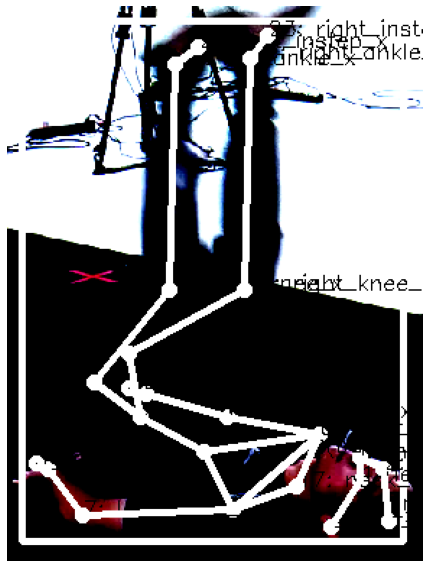

In [54]:
utils.draw_keypoints_show(imgs[0].permute(1, 2, 0).numpy(), keypoints[0].type(torch.int64).numpy() * 4)

데이터 자체는 잘 만들어진게 맞음

In [55]:
pred_heatmaps1 = pose_model1(imgs)
pred_heatmaps2 = pose_model2(imgs)

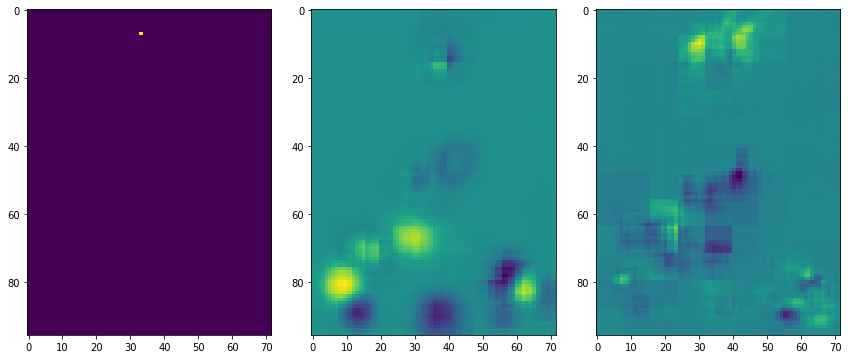

In [62]:
j = 22
plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
plt.imshow(target_heatmaps[0][j])
plt.subplot(1, 3, 2)
plt.imshow(pred_heatmaps1[0][j])
plt.subplot(1, 3, 3)
plt.imshow(pred_heatmaps2[0][j])
plt.tight_layout()
plt.show()

In [158]:
pred_heatmaps1.min()

tensor(-0.4513)

예측 자체는 둘 다 비슷한데, 기존 weight는 정답 위치 외에는 다 0으로 굉장히 깨끗하게 나옴  
어떻게 한거지?

JointMSE랑 CE랑 합쳐야하나?